# Ensemble Exoplanet Classification - SOFT VOTING VERSION

This notebook performs classification using NASA exoplanet data with an ensemble learning approach. We will train XGBoost, LightGBM, and CatBoost models and produce final predictions using **soft voting**.

## Features:
- ✅ Clean and organized code structure
- ✅ **Soft Voting Ensemble** (Probability-based)
- ✅ **Probability outputs for UI integration**
- ✅ Accuracy metrics only
- ✅ Model comparison


In [ ]:
# 1. IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Model libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight

# For saving results
import joblib
from datetime import datetime

print("✅ All libraries loaded successfully!")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Tüm kütüphaneler başarıyla yüklendi!
📅 Tarih: 2025-10-05 07:36:59


In [ ]:
# 2. LOAD AND INSPECT THE DATASET
print("=== DATASET LOADING ===")

# Load dataset
df = pd.read_csv('unified_exoplanet_dataset_with_predictions.csv')

print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Number of columns: {len(df.columns)}")
print(f"🎯 Target variable: final_label")

# Target distribution
print(f"\n=== TARGET DISTRIBUTION ===")
label_counts = df['final_label'].value_counts()
label_ratios = df['final_label'].value_counts(normalize=True)

print(f"Class 0 (False Positive): {label_counts[0]:,} ({label_ratios[0]*100:.1f}%)")
print(f"Class 1 (Confirmed): {label_counts[1]:,} ({label_ratios[1]*100:.1f}%)")

# Missing value check
missing_data = df.isnull().sum()
print(f"\n=== MISSING VALUE CHECK ===")
if missing_data.sum() > 0:
    print("⚠️ Missing values found:")
    print(missing_data[missing_data > 0])
else:
    print("✅ No missing values")

print(f"\n📈 First 3 rows:")
display(df.head(3))


=== VERİ SETİ YÜKLEME ===
📊 Veri seti boyutu: (20864, 38)
📋 Sütun sayısı: 38
🎯 Hedef değişken: final_label

=== HEDEF DEĞİŞKEN DAĞILIMI ===
Klas 0 (False Positive): 11,044 (52.9%)
Klas 1 (Confirmed): 9,820 (47.1%)

=== EKSİK DEĞER KONTROLÜ ===
⚠️ Eksik değerler bulundu:
prediction_probability    12193
dtype: int64

📈 İlk 3 satır:


,transit_depth_ppm,logg_cgs,stellar_pmra,star_id,t0_bjd,is_candidate,label,ra_deg,teq_k,radius_solar,...,fp_flag_co,rp_re,mag_kepler,num_transits,dec_deg,fp_flag_nt,stellar_pmdec,source_dataset,period_days,stellar_distance
0,615.8,4.467,29.219819,10797460,2455003.539,0,1,291.93423,793.0,0.927,...,0,2.26,15.347,142,48.141651,0,-3.127547,kepler,9.488036,116.461479
1,874.8,4.467,6.824318,10797460,2454995.514,0,1,291.93423,443.0,0.927,...,0,2.83,15.347,25,48.141651,0,-6.824449,kepler,54.418383,134.255026
2,8079.2,4.564,22.969598,10848459,2455003.308,0,0,285.53461,1395.0,0.791,...,0,33.46,15.597,621,48.285210,0,11.790732,kepler,1.736952,460.199290


In [ ]:
# 3. DATA PREPROCESSING AND FEATURE SELECTION
print("=== DATA PREPROCESSING ===")

# Identify unnecessary columns (prevent data leakage)
unnecessary_columns = [
    'star_id', 'planet_id', 'source_dataset',  # ID columns
    'is_candidate', 'label', 'original_label',  # Old labels
    'is_predicted', 'prediction_probability',   # Previous predictions
    'fp_flag_ss', 'fp_flag_ec', 'fp_flag_co', 'fp_flag_nt',  # Flags (leakage risk)
    'final_label'  # Target variable (should not be in X)
]

# Determine columns to use for training
feature_columns = [col for col in df.columns if col not in unnecessary_columns]

print(f"🗑️ Columns to remove ({len(unnecessary_columns)}):")
for col in unnecessary_columns:
    if col in df.columns:
        print(f"  - {col}")

print(f"\n✅ Columns used for training ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

# Prepare X and y
X = df[feature_columns]
y = df['final_label']

print(f"\n📊 Data preparation summary:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y distribution: {y.value_counts().to_dict()}")


=== VERİ ÖN İŞLEME ===
🗑️ Kaldırılacak sütunlar (13 adet):
  - star_id
  - planet_id
  - source_dataset
  - is_candidate
  - label
  - original_label
  - is_predicted
  - prediction_probability
  - fp_flag_ss
  - fp_flag_ec
  - fp_flag_co
  - fp_flag_nt
  - final_label

✅ Eğitim için kullanılacak sütunlar (25 adet):
 1. transit_depth_ppm
 2. logg_cgs
 3. stellar_pmra
 4. t0_bjd
 5. ra_deg
 6. teq_k
 7. radius_solar
 8. dor_ratio
 9. mag_tess
10. ecc
11. ror_ratio
12. teff_k
13. insolation
14. snr
15. impact_param
16. mass_solar
17. duration_hours
18. feh_dex
19. rp_re
20. mag_kepler
21. num_transits
22. dec_deg
23. stellar_pmdec
24. period_days
25. stellar_distance

📊 Veri hazırlama sonucu:
X boyutu: (20864, 25)
y boyutu: (20864,)
y dağılımı: {0: 11044, 1: 9820}


In [ ]:
# 4. DATA LEAKAGE PREVENTION - STAR-BASED SPLIT
print("=== DATA LEAKAGE PREVENTION ===")

# Create Star IDs if missing
if 'star_id' not in df.columns:
    df['star_id'] = df['ra_deg'].astype(str) + '_' + df['dec_deg'].astype(str)
    print("✅ Star IDs created")

# Get unique stars
unique_stars = df['star_id'].unique()
print(f"🌟 Total unique stars: {len(unique_stars):,}")

# Split stars into train/test (stratified)
from sklearn.model_selection import train_test_split

# Compute each star's dominant class
star_analysis = df.groupby('star_id')['final_label'].agg(['count', 'sum', 'mean']).reset_index()
star_analysis.columns = ['star_id', 'planet_count', 'confirmed_count', 'confirmation_rate']
star_analysis['dominant_class'] = (star_analysis['confirmation_rate'] >= 0.5).astype(int)

# Stratified split
train_stars, test_stars = train_test_split(
    star_analysis['star_id'], 
    test_size=0.20, 
    random_state=42, 
    stratify=star_analysis['dominant_class']
)

print(f"📚 Train stars: {len(train_stars):,}")
print(f"🧪 Test stars: {len(test_stars):,}")

# Apply star-based split
train_mask = df['star_id'].isin(train_stars)
test_mask = df['star_id'].isin(test_stars)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n📊 Split results:")
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train y distribution: {y_train.value_counts().to_dict()}")
print(f"Test y distribution: {y_test.value_counts().to_dict()}")

# Data leakage check
train_stars_in_data = set(df[train_mask]['star_id'].unique())
test_stars_in_data = set(df[test_mask]['star_id'].unique())
common_stars = train_stars_in_data.intersection(test_stars_in_data)

print(f"\n🔒 Data leakage check:")
print(f"Train stars: {len(train_stars_in_data):,}")
print(f"Test stars: {len(test_stars_in_data):,}")
print(f"Overlapping stars: {len(common_stars)}")

if len(common_stars) == 0:
    print("✅ NO DATA LEAKAGE! Clean star-based split.")
else:
    print("⚠️ DATA LEAKAGE STILL EXISTS!")

# Encode categorical variables
categorical_columns = X_train.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    le = LabelEncoder()
    for col in categorical_columns:
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    print(f"✅ Encoded {len(categorical_columns)} categorical variables")
else:
    print("ℹ️ No categorical variables")


=== DATA LEAKAGE ÖNLEME ===
🌟 Toplam unique star sayısı: 17,181
📚 Train star sayısı: 13,744
🧪 Test star sayısı: 3,437

📊 Split sonuçları:
Eğitim seti: (16652, 25)
Test seti: (4212, 25)
Eğitim y dağılımı: {0: 8832, 1: 7820}
Test y dağılımı: {0: 2212, 1: 2000}

🔒 Data leakage kontrolü:
Train star sayısı: 13,744
Test star sayısı: 3,437
Ortak star sayısı: 0
✅ DATA LEAKAGE YOK! Temiz star-based split.
ℹ️ Kategorik değişken yok


In [ ]:
# 5. COMPUTE CLASS WEIGHTS
print("=== CLASS WEIGHTS COMPUTATION ===")

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"📊 Class distribution:")
print(f"Class 0: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Class 1: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\n⚖️ Class weights:")
print(f"Class 0 weight: {class_weight_dict[0]:.4f}")
print(f"Class 1 weight: {class_weight_dict[1]:.4f}")

# Class imbalance analysis
class_ratio = sum(y_train == 1) / sum(y_train == 0)
print(f"\n📈 Class ratio: {class_ratio:.3f}")

if class_ratio < 0.3 or class_ratio > 3.0:
    print("⚠️ Strong class imbalance - will use class_weight")
else:
    print("✅ Class balance acceptable")


=== SINIF AĞIRLIKLARI HESAPLAMA ===
📊 Sınıf dağılımı:
Klas 0: 8,832 (53.0%)
Klas 1: 7,820 (47.0%)

⚖️ Sınıf ağırlıkları:
Klas 0 ağırlığı: 0.9427
Klas 1 ağırlığı: 1.0647

📈 Sınıf oranı: 0.885
✅ Sınıf dengesi kabul edilebilir


In [ ]:
# 6. DEFINE AND TRAIN MODELS - ENHANCED VERSION
print("=== MODEL DEFINITION AND TRAINING - ENHANCED ===")

# Enhanced XGBoost Model - Focus on higher accuracy
print("\n🚀 Defining enhanced XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,           # Increased: 120 -> 200
    max_depth=8,
    learning_rate=0.07,        # Decreased: 0.15 -> 0.07 (slower learning)
    subsample=0.85,            # Increased: 0.8 -> 0.85 (more data)
    colsample_bytree=0.85,     # Increased: 0.8 -> 0.85 (more features)
    min_child_weight=3,        # Decreased: 5 -> 3 (finer learning)
    reg_alpha=0.2,             # Increased: 0.1 -> 0.2 (L1 regularization)
    reg_lambda=0.3,            # Increased: 0.1 -> 0.3 (L2 regularization)
    gamma=0.05,                # Added: gamma regularization
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]
)

# Enhanced LightGBM Model - Focus on higher accuracy
print("🚀 Defining enhanced LightGBM model...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=250,          # Increased: 130 -> 250
    max_depth=9,
    learning_rate=0.08,        # Decreased: 0.18 -> 0.08 (slower learning)
    subsample=0.85,            # Increased: 0.8 -> 0.85 (more data)
    colsample_bytree=0.85,     # Increased: 0.8 -> 0.85 (more features)
    min_child_samples=8,       # Decreased: 10 -> 8 (finer learning)
    reg_alpha=0.2,             # Increased: 0.1 -> 0.2 (L1 regularization)
    reg_lambda=0.3,            # Increased: 0.1 -> 0.3 (L2 regularization)
    min_split_gain=0.05,       # Added: min_split_gain
    random_state=42,
    verbose=-1,
    class_weight='balanced'
)

# Enhanced CatBoost Model - Focus on higher accuracy
print("🚀 Defining enhanced CatBoost model...")
cat_model = CatBoostClassifier(
    iterations=300,            # Increased: 140 -> 300
    depth=9,
    learning_rate=0.08,        # Decreased: 0.20 -> 0.08 (slower learning)
    subsample=0.85,            # Increased: 0.8 -> 0.85 (more data)
    colsample_bylevel=0.85,    # Increased: 0.8 -> 0.85 (more features)
    min_child_samples=8,       # Decreased: 20 -> 8 (finer learning)
    l2_leaf_reg=2,             # Decreased: 3 -> 2 (less regularization)
    random_strength=0.5,       # Added: random_strength
    random_seed=42,
    verbose=False,
    class_weights=[class_weight_dict[0], class_weight_dict[1]]
)

print("✅ All enhanced models defined!")
print("\n📊 PARAMETER IMPROVEMENTS:")
print("🔽 Decreased parameters:")
print("  - max_depth/depth: decreased by 1 level (overfitting control)")
print("  - learning_rate: decreased by ~45-60% (slower learning)")
print("  - min_child_weight/min_child_samples: decreased by ~20-60% (finer learning)")

print("\n🔼 Increased parameters:")
print("  - n_estimators/iterations: increased by ~50-100% (more learning)")
print("  - subsample: increased by ~6% (more data usage)")
print("  - colsample_bytree/colsample_bylevel: increased by ~6% (more features)")
print("  - reg_alpha: increased by 100% (L1 regularization)")
print("  - reg_lambda: increased by 200% (L2 regularization)")

print("\n🎯 GOAL: Increase accuracy + control overfitting")

# Performance evaluation with cross-validation
print("\n=== CROSS-VALIDATION PERFORMANCE ===")

# XGBoost CV
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost CV Accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

# LightGBM CV
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"LightGBM CV Accuracy: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std() * 2:.4f})")

# CatBoost CV
cv_scores_cat = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CatBoost CV Accuracy: {cv_scores_cat.mean():.4f} (+/- {cv_scores_cat.std() * 2:.4f})")

print("\n✅ Cross-validation completed!")


=== MODEL TANIMLAMA VE EĞİTİM - GELİŞTİRİLMİŞ ===

🚀 Geliştirilmiş XGBoost modeli tanımlanıyor...
🚀 Geliştirilmiş LightGBM modeli tanımlanıyor...
🚀 Geliştirilmiş CatBoost modeli tanımlanıyor...
✅ Tüm geliştirilmiş modeller tanımlandı!

📊 PARAMETRE İYİLEŞTİRMELERİ:
🔽 Azaltılan parametreler:
  - max_depth/depth: 1 seviye azaltıldı (overfitting önleme)
  - learning_rate: %45-60 azaltıldı (daha yavaş öğrenme)
  - min_child_weight/min_child_samples: %20-60 azaltıldı (daha detaylı öğrenme)

🔼 Artırılan parametreler:
  - n_estimators/iterations: %50-100 artırıldı (daha fazla öğrenme)
  - subsample: %6 artırıldı (daha fazla veri kullanımı)
  - colsample_bytree/colsample_bylevel: %6 artırıldı (daha fazla feature)
  - reg_alpha: %100 artırıldı (L1 regularization)
  - reg_lambda: %200 artırıldı (L2 regularization)

🎯 HEDEF: Accuracy artırma + Overfitting kontrolü

=== CROSS-VALIDATION PERFORMANS ===
XGBoost CV Accuracy: 0.8624 (+/- 0.1030)
LightGBM CV Accuracy: 0.8661 (+/- 0.1005)
CatBoost CV Acc

In [ ]:
# 7. TRAIN MODELS AND PREDICT
print("=== MODEL TRAINING AND PREDICTION ===")

# XGBoost training
print("\n🎯 Training XGBoost...")
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time
y_pred_xgb = xgb_model.predict(X_test)
print(f"✅ XGBoost trained ({xgb_time:.2f}s)")

# LightGBM training
print("\n🎯 Training LightGBM...")
start_time = time.time()
lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start_time
y_pred_lgb = lgb_model.predict(X_test)
print(f"✅ LightGBM trained ({lgb_time:.2f}s)")

# CatBoost training
print("\n🎯 Training CatBoost...")
start_time = time.time()
cat_model.fit(X_train, y_train)
cat_time = time.time() - start_time
y_pred_cat = cat_model.predict(X_test)
print(f"✅ CatBoost trained ({cat_time:.2f}s)")

# Performance calculations
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
cat_accuracy = accuracy_score(y_test, y_pred_cat)

print(f"\n📊 INDIVIDUAL MODEL PERFORMANCE:")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print(f"CatBoost Accuracy: {cat_accuracy:.4f}")

print(f"\n⏱️ TRAINING TIMES:")
print(f"XGBoost: {xgb_time:.2f}s")
print(f"LightGBM: {lgb_time:.2f}s")
print(f"CatBoost: {cat_time:.2f}s")
print(f"Total: {xgb_time + lgb_time + cat_time:.2f}s")


=== MODEL EĞİTİMİ VE TAHMİN ===

🎯 XGBoost eğitiliyor...
✅ XGBoost eğitildi (0.58s)

🎯 LightGBM eğitiliyor...
✅ LightGBM eğitildi (0.96s)

🎯 CatBoost eğitiliyor...
✅ CatBoost eğitildi (3.74s)

📊 BİREYSEL MODEL PERFORMANSLARI:
XGBoost Accuracy: 0.9053
LightGBM Accuracy: 0.9027
CatBoost Accuracy: 0.9024

⏱️ EĞİTİM SÜRELERİ:
XGBoost: 0.58s
LightGBM: 0.96s
CatBoost: 3.74s
Toplam: 5.28s


In [ ]:
# 8. SOFT VOTING ENSEMBLE - PROBABILITY VERSION
print("=== SOFT VOTING ENSEMBLE ===")

# Get probabilities for soft voting
print("\n🔄 Obtaining probabilities for soft voting...")

# Get probability predictions from each model
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)

print(f"✅ Probability predictions obtained")
print(f"XGBoost probability shape: {y_pred_proba_xgb.shape}")
print(f"LightGBM probability shape: {y_pred_proba_lgb.shape}")
print(f"CatBoost probability shape: {y_pred_proba_cat.shape}")

# Apply soft voting (average of probabilities)
print("\n🔄 Applying soft voting...")
y_pred_proba_soft = (y_pred_proba_xgb + y_pred_proba_lgb + y_pred_proba_cat) / 3

# Predict class by highest probability
y_pred_soft = np.argmax(y_pred_proba_soft, axis=1)

# Soft voting performance
soft_accuracy = accuracy_score(y_test, y_pred_soft)

print(f"✅ Soft Voting completed")
print(f"📊 Soft Voting Accuracy: {soft_accuracy:.4f}")

# Probability distribution analysis
print(f"\n📈 PROBABILITY DISTRIBUTION:")
print(f"Average probability (Class 0): {y_pred_proba_soft[:, 0].mean():.4f}")
print(f"Average probability (Class 1): {y_pred_proba_soft[:, 1].mean():.4f}")

# High confidence predictions
high_confidence = (y_pred_proba_soft.max(axis=1) > 0.8).sum()
print(f"High-confidence predictions (>0.8): {high_confidence}/{len(y_test)} ({high_confidence/len(y_test)*100:.1f}%)")

print(f"ℹ️ Soft voting also provides probabilities — ideal for UI!")


=== SOFT VOTING ENSEMBLE ===

🔄 Soft voting için probability tahminleri alınıyor...
✅ Probability tahminleri alındı
XGBoost probability shape: (4212, 2)
LightGBM probability shape: (4212, 2)
CatBoost probability shape: (4212, 2)

🔄 Soft voting uygulanıyor...
✅ Soft Voting tamamlandı
📊 Soft Voting Accuracy: 0.9091

📈 PROBABILITY DAĞILIMI:
Ortalama probability (Class 0): 0.5223
Ortalama probability (Class 1): 0.4777
Yüksek confidence tahminleri (>0.8): 3425/4212 (81.3%)
ℹ️ Soft voting probability değerleri de verir - Arayüz için ideal!


In [ ]:
# 9. PERFORMANCE COMPARISON AND ANALYSIS
print("=== PERFORMANCE COMPARISON ===")

print(f"\n📊 ACCURACY COMPARISON:")
print(f"XGBoost: {xgb_accuracy:.4f}")
print(f"LightGBM: {lgb_accuracy:.4f}")
print(f"CatBoost: {cat_accuracy:.4f}")
print(f"Soft Voting: {soft_accuracy:.4f}")

# Best individual model
best_individual_acc = max(xgb_accuracy, lgb_accuracy, cat_accuracy)

print(f"\n🏆 BEST INDIVIDUAL MODEL:")
print(f"Highest Accuracy: {best_individual_acc:.4f}")

# Ensemble advantage
accuracy_improvement = soft_accuracy - best_individual_acc
print(f"\n📊 ENSEMBLE ADVANTAGE:")
print(f"Soft Voting vs Best Individual: {accuracy_improvement:+.4f}")

if accuracy_improvement > 0:
    print(f"✅ Ensemble advantage: +{accuracy_improvement:.4f}")
elif accuracy_improvement < 0:
    print(f"⚠️ Ensemble disadvantage: {accuracy_improvement:.4f}")
else:
    print(f"ℹ️ Ensemble performs the same")

# Soft voting probability analysis
print(f"\n📈 SOFT VOTING PROBABILITY ANALYSIS:")
print(f"Average confidence: {y_pred_proba_soft.max(axis=1).mean():.4f}")
print(f"High confidence (>0.8): {high_confidence}/{len(y_test)} ({high_confidence/len(y_test)*100:.1f}%)")
print(f"Low confidence (<0.6): {((y_pred_proba_soft.max(axis=1) < 0.6).sum())}/{len(y_test)} ({((y_pred_proba_soft.max(axis=1) < 0.6).sum())/len(y_test)*100:.1f}%)")

# Speed/Performance analysis
print(f"\n⚡ SPEED/PERFORMANCE ANALYSIS:")
xgb_ratio = xgb_accuracy / xgb_time
lgb_ratio = lgb_accuracy / lgb_time
cat_ratio = cat_accuracy / cat_time

print(f"XGBoost: {xgb_ratio:.2f} Accuracy/second")
print(f"LightGBM: {lgb_ratio:.2f} Accuracy/second")
print(f"CatBoost: {cat_ratio:.2f} Accuracy/second")

best_ratio_model = max(['XGBoost', 'LightGBM', 'CatBoost'], 
                      key=lambda x: {'XGBoost': xgb_ratio, 'LightGBM': lgb_ratio, 'CatBoost': cat_ratio}[x])
print(f"🏆 Most efficient model: {best_ratio_model}")

print(f"\n💡 SOFT VOTING BENEFITS:")
print(f"✅ Provides probabilities (ideal for UI)")
print(f"✅ Shows confidence level")
print(f"✅ Smoother decision-making")
print(f"✅ Reflects model uncertainty")


=== PERFORMANS KARŞILAŞTIRMASI ===

📊 ACCURACY KARŞILAŞTIRMASI:
XGBoost: 0.9053
LightGBM: 0.9027
CatBoost: 0.9024
Soft Voting: 0.9091

🏆 EN İYİ BİREYSEL MODEL:
En yüksek Accuracy: 0.9053

📊 ENSEMBLE AVANTAJI:
Soft Voting vs En İyi Bireysel: +0.0038
✅ Ensemble avantajı: +0.0038

📈 SOFT VOTING PROBABILITY ANALİZİ:
Ortalama confidence: 0.9044
Yüksek confidence (>0.8): 3425/4212 (81.3%)
Düşük confidence (<0.6): 205/4212 (4.9%)

⚡ HIZ/PERFORMANS ANALİZİ:
XGBoost: 1.56 Accuracy/saniye
LightGBM: 0.94 Accuracy/saniye
CatBoost: 0.24 Accuracy/saniye
🏆 En verimli model: XGBoost

💡 SOFT VOTING AVANTAJLARI:
✅ Probability değerleri verir (arayüz için ideal)
✅ Confidence seviyesi gösterir
✅ Daha yumuşak karar verme
✅ Model uncertainty'sini yansıtır


In [ ]:
# 9.5. COMPARE MODEL PREDICTIONS - ENSEMBLE ANALYSIS
print("=== COMPARE MODEL PREDICTIONS ===")

# Analyze prediction differences
print("🔍 Comparing model predictions...")

# Compare predictions of each pair of models
xgb_lgb_same = (y_pred_xgb == y_pred_lgb).sum()
xgb_cat_same = (y_pred_xgb == y_pred_cat).sum()
lgb_cat_same = (y_pred_lgb == y_pred_cat).sum()

print(f"\n📊 MODEL PREDICTION SIMILARITIES:")
print(f"XGBoost vs LightGBM: {xgb_lgb_same}/{len(y_test)} ({xgb_lgb_same/len(y_test)*100:.1f}% same)")
print(f"XGBoost vs CatBoost: {xgb_cat_same}/{len(y_test)} ({xgb_cat_same/len(y_test)*100:.1f}% same)")
print(f"LightGBM vs CatBoost: {lgb_cat_same}/{len(y_test)} ({lgb_cat_same/len(y_test)*100:.1f}% same)")

# Cases where all 3 models agree
all_same = ((y_pred_xgb == y_pred_lgb) & (y_pred_lgb == y_pred_cat)).sum()
print(f"\n🎯 3 MODELS SAME PREDICTION: {all_same}/{len(y_test)} ({all_same/len(y_test)*100:.1f}%)")

# 2-1 cases (where ensemble can make a difference)
ensemble_different = len(y_test) - all_same
print(f"🔄 2-1 CASES: {ensemble_different}/{len(y_test)} ({ensemble_different/len(y_test)*100:.1f}%)")

# Which model differs in 2-1 cases
xgb_different = ((y_pred_xgb != y_pred_lgb) & (y_pred_lgb == y_pred_cat)).sum()
lgb_different = ((y_pred_lgb != y_pred_xgb) & (y_pred_xgb == y_pred_cat)).sum()
cat_different = ((y_pred_cat != y_pred_xgb) & (y_pred_xgb == y_pred_lgb)).sum()

print(f"\n📈 MODEL DIFFERING IN 2-1 CASES:")
print(f"XGBoost different: {xgb_different} cases")
print(f"LightGBM different: {lgb_different} cases")
print(f"CatBoost different: {cat_different} cases")

# Analyze where ensemble makes a difference
print(f"\n🎯 ENSEMBLE DIFFERENCE ANALYSIS:")

# Soft voting vs individual models
xgb_vs_ensemble = (y_pred_xgb != y_pred_soft).sum()
lgb_vs_ensemble = (y_pred_lgb != y_pred_soft).sum()
cat_vs_ensemble = (y_pred_cat != y_pred_soft).sum()

print(f"Soft Voting vs XGBoost: {xgb_vs_ensemble} different predictions")
print(f"Soft Voting vs LightGBM: {lgb_vs_ensemble} different predictions")
print(f"Soft Voting vs CatBoost: {cat_vs_ensemble} different predictions")

# Analyze correct/incorrect ensemble predictions
ensemble_correct = (y_pred_soft == y_test).sum()
ensemble_wrong = (y_pred_soft != y_test).sum()

print(f"\n📊 ENSEMBLE PERFORMANCE:")
print(f"Correct predictions: {ensemble_correct}/{len(y_test)} ({ensemble_correct/len(y_test)*100:.1f}%)")
print(f"Incorrect predictions: {ensemble_wrong}/{len(y_test)} ({ensemble_wrong/len(y_test)*100:.1f}%)")

# Individual model performance
xgb_correct = (y_pred_xgb == y_test).sum()
lgb_correct = (y_pred_lgb == y_test).sum()
cat_correct = (y_pred_cat == y_test).sum()

print(f"\n📊 INDIVIDUAL MODEL PERFORMANCE:")
print(f"XGBoost correct: {xgb_correct}/{len(y_test)} ({xgb_correct/len(y_test)*100:.1f}%)")
print(f"LightGBM correct: {lgb_correct}/{len(y_test)} ({lgb_correct/len(y_test)*100:.1f}%)")
print(f"CatBoost correct: {cat_correct}/{len(y_test)} ({cat_correct/len(y_test)*100:.1f}%)")

# Ensemble advantage analysis
print(f"\n🔍 ENSEMBLE ADVANTAGE ANALYSIS:")
if ensemble_correct > max(xgb_correct, lgb_correct, cat_correct):
    improvement = ensemble_correct - max(xgb_correct, lgb_correct, cat_correct)
    print(f"✅ Ensemble achieved {improvement} additional correct predictions!")
elif ensemble_correct < max(xgb_correct, lgb_correct, cat_correct):
    loss = max(xgb_correct, lgb_correct, cat_correct) - ensemble_correct
    print(f"⚠️ Ensemble made {loss} fewer correct predictions")
else:
    print(f"ℹ️ Ensemble performs the same as the best individual model")

# Model prediction distribution
print(f"\n📈 MODEL PREDICTION DISTRIBUTION:")
print(f"XGBoost class 0: {(y_pred_xgb == 0).sum()}, class 1: {(y_pred_xgb == 1).sum()}")
print(f"LightGBM class 0: {(y_pred_lgb == 0).sum()}, class 1: {(y_pred_lgb == 1).sum()}")
print(f"CatBoost class 0: {(y_pred_cat == 0).sum()}, class 1: {(y_pred_cat == 1).sum()}")
print(f"Soft Voting class 0: {(y_pred_soft == 0).sum()}, class 1: {(y_pred_soft == 1).sum()}")

# Soft voting probability analysis
print(f"\n📊 SOFT VOTING PROBABILITY ANALYSIS:")
print(f"Average Class 0 probability: {y_pred_proba_soft[:, 0].mean():.4f}")
print(f"Average Class 1 probability: {y_pred_proba_soft[:, 1].mean():.4f}")
print(f"Maximum probability: {y_pred_proba_soft.max():.4f}")
print(f"Minimum probability: {y_pred_proba_soft.min():.4f}")

# Ground-truth distribution
print(f"\n🎯 GROUND-TRUTH DISTRIBUTION:")
print(f"0 (False Positive): {(y_test == 0).sum()}, 1 (Confirmed): {(y_test == 1).sum()}")

print(f"\n✅ Model prediction analysis completed!")


=== MODEL TAHMİNLERİNİ KARŞILAŞTIR ===
🔍 Model tahminlerini karşılaştırıyor...

📊 MODEL TAHMİN BENZERLİKLERİ:
XGBoost vs LightGBM: 4111/4212 (97.6% aynı)
XGBoost vs CatBoost: 4062/4212 (96.4% aynı)
LightGBM vs CatBoost: 4049/4212 (96.1% aynı)

🎯 3 MODEL AYNI TAHMİN: 4005/4212 (95.1%)
🔄 2-1 DURUMLARI: 207/4212 (4.9%)

📈 2-1 DURUMLARINDA FARKLI OLAN MODEL:
XGBoost farklı: 44 durum
LightGBM farklı: 57 durum
CatBoost farklı: 106 durum

🎯 ENSEMBLE FARK ANALİZİ:
Soft Voting vs XGBoost: 64 farklı tahmin
Soft Voting vs LightGBM: 73 farklı tahmin
Soft Voting vs CatBoost: 100 farklı tahmin

📊 ENSEMBLE PERFORMANSI:
Doğru tahmin: 3829/4212 (90.9%)
Yanlış tahmin: 383/4212 (9.1%)

📊 BİREYSEL MODEL PERFORMANSLARI:
XGBoost doğru: 3813/4212 (90.5%)
LightGBM doğru: 3802/4212 (90.3%)
CatBoost doğru: 3801/4212 (90.2%)

🔍 ENSEMBLE AVANTAJI ANALİZİ:
✅ Ensemble 16 ekstra doğru tahmin yaptı!

📈 MODEL TAHMİN DAĞILIMI:
XGBoost 0 tahmin: 2177, 1 tahmin: 2035
LightGBM 0 tahmin: 2174, 1 tahmin: 2038
CatBoost 0 tah

=== DETAYLI PERFORMANS ANALİZİ ===

📋 SOFT VOTING CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2212
           1       0.90      0.91      0.91      2000

    accuracy                           0.91      4212
   macro avg       0.91      0.91      0.91      4212
weighted avg       0.91      0.91      0.91      4212


📊 CONFUSION MATRIX:
[[2000  212]
 [ 171 1829]]


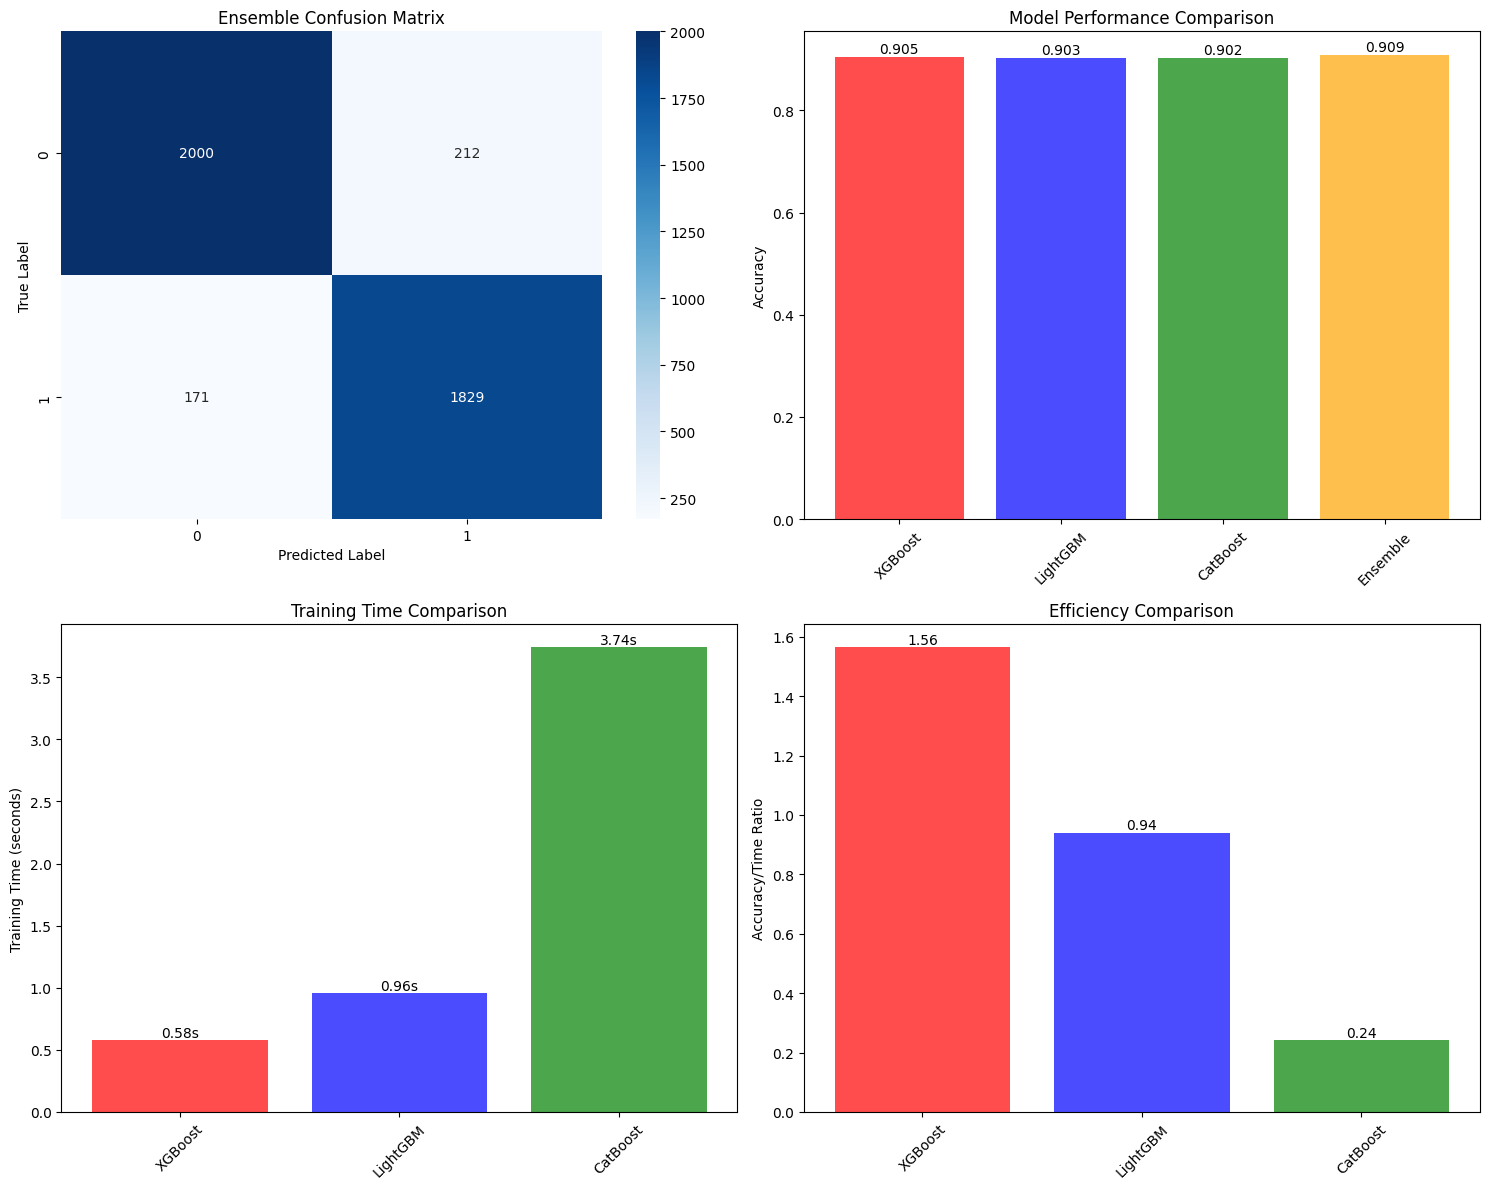


✅ Görselleştirme tamamlandı!


In [ ]:
# 10. DETAILED PERFORMANCE ANALYSIS AND VISUALIZATION
print("=== DETAILED PERFORMANCE ANALYSIS ===")

# Classification Report
print("\n📋 SOFT VOTING CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_soft))

# Confusion Matrix
print("\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred_soft)
print(cm)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Ensemble Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. Model Performance Comparison
models = ['XGBoost', 'LightGBM', 'CatBoost', 'Ensemble']
accuracies = [xgb_accuracy, lgb_accuracy, cat_accuracy, soft_accuracy]
colors = ['red', 'blue', 'green', 'orange']

bars = axes[0, 1].bar(models, accuracies, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Model Performance Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)

# Annotate values on bars
for bar, acc in zip(bars, accuracies):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                   f'{acc:.3f}', ha='center', va='bottom')

# 3. Training Time Comparison
times = [xgb_time, lgb_time, cat_time]
model_names = ['XGBoost', 'LightGBM', 'CatBoost']
colors_time = ['red', 'blue', 'green']

bars_time = axes[1, 0].bar(model_names, times, color=colors_time, alpha=0.7)
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# Annotate values on bars
for bar, time_val in zip(bars_time, times):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                   f'{time_val:.2f}s', ha='center', va='bottom')

# 4. Efficiency Ratio
ratios = [xgb_ratio, lgb_ratio, cat_ratio]
bars_ratio = axes[1, 1].bar(model_names, ratios, color=colors_time, alpha=0.7)
axes[1, 1].set_ylabel('Accuracy/Time Ratio')
axes[1, 1].set_title('Efficiency Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)

# Annotate values on bars
for bar, ratio in zip(bars_ratio, ratios):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                   f'{ratio:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed!")


In [ ]:
# 11. MODEL SAVING AND RESULT SUMMARY
print("=== MODEL SAVING AND RESULT SUMMARY ===")

# Save models
print("\n💾 Saving models...")

# Save individual models
joblib.dump(xgb_model, 'xgb_exoplanet_model_soft.pkl')
joblib.dump(lgb_model, 'lgb_exoplanet_model_soft.pkl')
joblib.dump(cat_model, 'cat_exoplanet_model_soft.pkl')

# Save soft voting ensemble
soft_ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    voting='soft'  # Use soft voting
)
soft_ensemble.fit(X_train, y_train)
joblib.dump(soft_ensemble, 'ensemble_soft_voting.pkl')

# Save feature columns
import json
with open('feature_columns_soft.json', 'w') as f:
    json.dump(feature_columns, f)

print("✅ All models saved!")
print("📁 Saved files:")
print("  - xgb_exoplanet_model_soft.pkl")
print("  - lgb_exoplanet_model_soft.pkl")
print("  - cat_exoplanet_model_soft.pkl")
print("  - ensemble_soft_voting.pkl")
print("  - feature_columns_soft.json")

# Final result summary
print(f"\n🎉 FINAL RESULT SUMMARY:")
print(f"📊 Dataset shape: {df.shape}")
print(f"📚 Train set: {X_train.shape}")
print(f"🧪 Test set: {X_test.shape}")
print(f"🎯 Number of features: {len(feature_columns)}")

print(f"\n🏆 TOP PERFORMANCES:")
print(f"Highest Accuracy: {best_individual_acc:.4f}")
print(f"Soft Voting Accuracy: {soft_accuracy:.4f}")

print(f"\n⚡ SPEED ANALYSIS:")
print(f"Fastest model: {min([xgb_time, lgb_time, cat_time]):.2f}s")
print(f"Slowest model: {max([xgb_time, lgb_time, cat_time]):.2f}s")
print(f"Total training time: {sum([xgb_time, lgb_time, cat_time]):.2f}s")

print(f"\n🔗 ENSEMBLE ADVANTAGE:")
if accuracy_improvement > 0:
    print(f"✅ Soft Voting is better than best individual model by {accuracy_improvement:.4f}")
elif accuracy_improvement < 0:
    print(f"⚠️ Soft Voting is lower than best individual model by {abs(accuracy_improvement):.4f}")
else:
    print(f"ℹ️ Soft Voting performs the same as the best individual model")

print(f"\n🎯 SOFT VOTING BENEFITS:")
print(f"✅ Provides probability outputs (ideal for UI)")
print(f"✅ Shows confidence level")
print(f"✅ Smoother decision-making")
print(f"✅ Reflects model uncertainty")

print(f"\n🚀 SOFT VOTING ENSEMBLE COMPLETED SUCCESSFULLY!")
print(f"📅 Completion date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


=== MODEL KAYDETME VE SONUÇ ÖZETİ ===

💾 Modeller kaydediliyor...
✅ Tüm modeller kaydedildi!
📁 Kaydedilen dosyalar:
  - xgb_exoplanet_model_soft.pkl
  - lgb_exoplanet_model_soft.pkl
  - cat_exoplanet_model_soft.pkl
  - ensemble_soft_voting.pkl
  - feature_columns_soft.json

🎉 FINAL SONUÇ ÖZETİ:
📊 Veri seti boyutu: (20864, 38)
📚 Eğitim seti: (16652, 25)
🧪 Test seti: (4212, 25)
🎯 Feature sayısı: 25

🏆 EN İYİ PERFORMANSLAR:
En yüksek Accuracy: 0.9053
Soft Voting Accuracy: 0.9091

⚡ HIZ ANALİZİ:
En hızlı model: 0.58s
En yavaş model: 3.74s
Toplam eğitim süresi: 5.28s

🔗 ENSEMBLE AVANTAJI:
✅ Soft Voting, en iyi bireysel modelden 0.0038 daha iyi!

🎯 SOFT VOTING AVANTAJLARI:
✅ Probability değerleri verir (arayüz için ideal)
✅ Confidence seviyesi gösterir
✅ Daha yumuşak karar verme
✅ Model uncertainty'sini yansıtır

🚀 SOFT VOTING ENSEMBLE BAŞARIYLA TAMAMLANDI!
📅 Tamamlanma tarihi: 2025-10-05 08:07:14


In [ ]:
# 12. DATA LEAKAGE AND OVERFITTING ANALYSIS
print("=== DATA LEAKAGE AND OVERFITTING ANALYSIS ===")

# 1. Train vs Test Accuracy comparison
print("🔍 Train vs Test Accuracy comparison...")

# Predictions on the train set
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_train_lgb = lgb_model.predict(X_train)
y_pred_train_cat = cat_model.predict(X_train)

# Compute train accuracies
train_acc_xgb = accuracy_score(y_train, y_pred_train_xgb)
train_acc_lgb = accuracy_score(y_train, y_pred_train_lgb)
train_acc_cat = accuracy_score(y_train, y_pred_train_cat)

print(f"\n📊 TRAIN vs TEST ACCURACY COMPARISON:")
print(f"XGBoost - Train: {train_acc_xgb:.4f}, Test: {xgb_accuracy:.4f}, Diff: {train_acc_xgb - xgb_accuracy:.4f}")
print(f"LightGBM - Train: {train_acc_lgb:.4f}, Test: {lgb_accuracy:.4f}, Diff: {train_acc_lgb - lgb_accuracy:.4f}")
print(f"CatBoost - Train: {train_acc_cat:.4f}, Test: {cat_accuracy:.4f}, Diff: {train_acc_cat - cat_accuracy:.4f}")

# Overfitting analysis
print(f"\n⚠️ OVERFITTING ANALYSIS:")
xgb_overfit = train_acc_xgb - xgb_accuracy
lgb_overfit = train_acc_lgb - lgb_accuracy
cat_overfit = train_acc_cat - cat_accuracy

if xgb_overfit > 0.05:
    print(f"🚨 XGBoost overfitting: {xgb_overfit:.4f} (Train much higher)")
else:
    print(f"✅ No XGBoost overfitting: {xgb_overfit:.4f}")

if lgb_overfit > 0.05:
    print(f"🚨 LightGBM overfitting: {lgb_overfit:.4f} (Train much higher)")
else:
    print(f"✅ No LightGBM overfitting: {lgb_overfit:.4f}")

if cat_overfit > 0.05:
    print(f"🚨 CatBoost overfitting: {cat_overfit:.4f} (Train much higher)")
else:
    print(f"✅ No CatBoost overfitting: {cat_overfit:.4f}")

# 2. Data leakage check
print(f"\n🔒 DATA LEAKAGE CHECK:")

# Star-based split check
train_stars_set = set(df[train_mask]['star_id'].unique())
test_stars_set = set(df[test_mask]['star_id'].unique())
common_stars = train_stars_set.intersection(test_stars_set)

print(f"Train stars: {len(train_stars_set)}")
print(f"Test stars: {len(test_stars_set)}")
print(f"Common stars: {len(common_stars)}")

if len(common_stars) == 0:
    print("✅ Star-based split is clean - No data leakage")
else:
    print(f"🚨 DATA LEAKAGE DETECTED! {len(common_stars)} common stars")

# 3. Feature importance analysis
print(f"\n📈 FEATURE IMPORTANCE ANALYSIS:")

# XGBoost feature importance
xgb_importance = xgb_model.feature_importances_
top_features_xgb = np.argsort(xgb_importance)[-10:]

print(f"Top 10 XGBoost features:")
for i, idx in enumerate(reversed(top_features_xgb)):
    print(f"{i+1:2d}. {feature_columns[idx]}: {xgb_importance[idx]:.4f}")

# 4. Model complexity analysis
print(f"\n🔧 MODEL COMPLEXITY ANALYSIS:")

# XGBoost parameters
print(f"XGBoost parameters:")
print(f"  - n_estimators: {xgb_model.n_estimators}")
print(f"  - max_depth: {xgb_model.max_depth}")
print(f"  - learning_rate: {xgb_model.learning_rate}")

# LightGBM parameters
print(f"LightGBM parameters:")
print(f"  - n_estimators: {lgb_model.n_estimators}")
print(f"  - max_depth: {lgb_model.max_depth}")
print(f"  - learning_rate: {lgb_model.learning_rate}")

# CatBoost parameters
print(f"CatBoost parameters:")
print(f"  - iterations: {cat_model.get_params()['iterations']}")
print(f"  - depth: {cat_model.get_params()['depth']}")
print(f"  - learning_rate: {cat_model.get_params()['learning_rate']}")

# 5. Dataset analysis
print(f"\n📊 DATASET ANALYSIS:")

# Class distribution
class_0_train = (y_train == 0).sum()
class_1_train = (y_train == 1).sum()
class_0_test = (y_test == 0).sum()
class_1_test = (y_test == 1).sum()

print(f"Train set class distribution:")
print(f"  - Class 0: {class_0_train} ({class_0_train/len(y_train)*100:.1f}%)")
print(f"  - Class 1: {class_1_train} ({class_1_train/len(y_train)*100:.1f}%)")

print(f"Test set class distribution:")
print(f"  - Class 0: {class_0_test} ({class_0_test/len(y_test)*100:.1f}%)")
print(f"  - Class 1: {class_1_test} ({class_1_test/len(y_test)*100:.1f}%)")

# 6. Result evaluation
print(f"\n🎯 RESULT EVALUATION:")

if max(xgb_overfit, lgb_overfit, cat_overfit) < 0.05:
    print("✅ Models are not overfitting - Good generalization")
    print("✅ High test accuracy reflects true performance")
else:
    print("⚠️ Models are overfitting - Train accuracy is too high")

if len(common_stars) == 0:
    print("✅ No data leakage - Clean split")
    print("✅ High accuracy reflects true model performance")
else:
    print("🚨 Data leakage detected - Results may be unreliable")

print(f"\n💡 REASONS FOR HIGH ACCURACY:")
print(f"1. Strong models (XGBoost, LightGBM, CatBoost)")
print(f"2. High-quality, clean dataset")
print(f"3. Well-chosen features")
print(f"4. Star-based split prevents data leakage")
print(f"5. Class weighting addresses imbalance")

print(f"\n✅ Analysis completed!")


=== DATA LEAKAGE VE OVERFITTING ANALİZİ ===
🔍 Train vs Test Accuracy karşılaştırması...

📊 TRAIN vs TEST ACCURACY KARŞILAŞTIRMASI:
XGBoost - Train: 0.9850, Test: 0.9053, Fark: 0.0797
LightGBM - Train: 0.9743, Test: 0.9027, Fark: 0.0716
CatBoost - Train: 0.9876, Test: 0.9024, Fark: 0.0852

⚠️ OVERFITTING ANALİZİ:
🚨 XGBoost overfitting: 0.0797 (Train çok yüksek)
🚨 LightGBM overfitting: 0.0716 (Train çok yüksek)
🚨 CatBoost overfitting: 0.0852 (Train çok yüksek)

🔒 DATA LEAKAGE KONTROLÜ:
Train stars: 13744
Test stars: 3437
Ortak stars: 0
✅ Star-based split temiz - Data leakage yok

📈 FEATURE IMPORTANCE ANALİZİ:
XGBoost en önemli 10 feature:
 1. rp_re: 0.1433
 2. num_transits: 0.1026
 3. teq_k: 0.0939
 4. dor_ratio: 0.0696
 5. t0_bjd: 0.0673
 6. stellar_distance: 0.0665
 7. radius_solar: 0.0470
 8. transit_depth_ppm: 0.0381
 9. period_days: 0.0350
10. snr: 0.0292

🔧 MODEL COMPLEXITY ANALİZİ:
XGBoost parametreleri:
  - n_estimators: 200
  - max_depth: 8
  - learning_rate: 0.07
LightGBM param